In [66]:
import json

import pandas as pd
import numpy as np
import re, os, sys
import matplotlib.pyplot as plt

import nltk
import nltk.corpus

import keras

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/fcasas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

<a id="cuarto"></a>
## 3. CNN sobre texto

Cuando oimos sobre redes neuronales convolucionales (CNN) normalmente pensamos en visión artificial. Las CNN fueron responsables de los principales avances en la clasificación de imágenes y son el núcleo de la mayoría de los sistemas de *Computer Vision* en la actualidad, desde el etiquetado automático de fotos de Facebook hasta los autos que conducen por sí mismos.

Más recientemente, también hemos empezado a aplicar CNN a problemas de procesamiento del lenguaje natural (NLP) y hemos obtenido resultados interesantes. Como sabemos, las redes convolucionales tienen importantes ventajas como invarianza a rotaciones y traslaciones así como la conectividad local (características de nivel inferior en una representación de nivel superior), además de lo que las hace fuertemente ventajosas, el **compartir** parámetros.


**¿Cómo se aplica esto a NLP?**  
En esta experimentación apicaremos una red CNN al dataset  __[Adzuna](https://www.kaggle.com/c/job-salary-prediction)__ que contiene cientos de miles de registros que en su mayoría corresponden a texto no estructurado versus sólo unos pocos estructurados. Los registros pueden estar en varios formatos diferentes debido a los cientos de diferentes fuentes de registros, los cuales corresponden a anuncios de empleadores en busca de trabajadores.  
Es decir, cada fila es un anuncio que, en estricto rigor, representa una sentencia típicamente trabajada como vectores de word embeddings como **word2vec** o **GloVe**. Así, para una frase de 10 palabras bajo representaciones de *embeddings* utilizando 100 dimensiones tendríamos una matriz de 10 × 100 como entrada, lo que simularía nuestra "imagen".


Su tarea es entonces, predecir el salario (valor continuo) de un determinado anuncio en base al texto indicado en éste. Igualmente puede valerse de otros atributos del anuncio como por ejemplo la ubicación, tipo de contrato, etc. 


A continuación se presenta un código de guía para leer los archivos y pre-procesarlos. Deberá añadir y realizar lo que estime conveniente.

In [2]:
stoplist = nltk.corpus.stopwords.words('english')
df = pd.read_csv("all/Train_rev1.csv")
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [3]:
POS_TO_WORDNET = {
    'JJ':   nltk.corpus.wordnet.ADJ,
    'JJR':  nltk.corpus.wordnet.ADJ,
    'JJS':  nltk.corpus.wordnet.ADJ,
    'RB':   nltk.corpus.wordnet.ADV,
    'RBR':  nltk.corpus.wordnet.ADV,
    'RBS':  nltk.corpus.wordnet.ADV,
    'NN':   nltk.corpus.wordnet.NOUN,
    'NNP':  nltk.corpus.wordnet.NOUN,
    'NNS':  nltk.corpus.wordnet.NOUN,
    'NNPS': nltk.corpus.wordnet.NOUN,
    'VB':   nltk.corpus.wordnet.VERB,
    'VBG':  nltk.corpus.wordnet.VERB,
    'VBD':  nltk.corpus.wordnet.VERB,
    'VBN':  nltk.corpus.wordnet.VERB,
    'VBP':  nltk.corpus.wordnet.VERB,
    'VBZ':  nltk.corpus.wordnet.VERB,
}

lemmatizer = nltk.WordNetLemmatizer()

def penn_to_wn(tag):
    return POS_TO_WORDNET.get(tag,nltk.corpus.wordnet.NOUN)

# precompile regexes
re1 = re.compile(r'[^\w]')
re2 = re.compile(r'[^\w]')
re3 = re.compile(r'\b[a-z]\b')
re4 = re.compile(r'\b[a-z][a-z]\b')
re5 = re.compile(r'\b[0-9]\b')
re6 = re.compile(r'\b[0-9][0-9]\b')
re7 = re.compile(r'\b[0-9][0-9][0-9]\b')
re8 = re.compile(r'[^\w.]')

def preproc_string(s):
    s = s.lower()
    s = re1.sub(' ',s)
    s = re2.sub(' ',s)
    s = re3.sub(' ',s)
    s = re4.sub(' ',s)
    s = re5.sub(' ',s)
    s = re6.sub(' ',s)
    s = re7.sub(' ',s)
    s = re8.sub(' ',s)
    text = nltk.word_tokenize(s)
    # pos tagging
    tags = nltk.pos_tag(text)
    # lemmatization
    lemms = [lemmatizer.lemmatize(x,penn_to_wn(y)) for x,y in tags]
    # remove stopwords
    lemms = [x for x in lemms if x not in stoplist]
    return lemms

> Para usar la lematización correctamente, se usa el POS tagger para obtener los tags de cada palabra dentro de su oración correspondiente, estos tags le permiten al WordLemmatizer recortar correctamente la palabra, dado que de otra manera las considera un *noun*.

> Para acelerar el preprocesamiento (que tomó un tiempo considerable) se probó a compilar las expresiones regulares por separado antes de utilizarlas.

In [63]:
# Example preprocessed sentence.
print(df['FullDescription'][0])
print()
print(preproc_string(df['FullDescription'][0]))

Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Engineering Systems Analyst Dorking Surrey Salary ****K

['engineering', 'system', 'analyst', 'dorking', 'surrey', 'salary', 'client', 'locate', 'dorking', 'surrey', 'look', 'engineering', 'system', 'analyst', 'client', 'provide', 'specialist', 'software', 'development', 'keywords', 'mathematical', 'modelling', 'risk', 'analysis', 'system', 'model', 'optimisation', 'miser', 'pioneeer', 'engineering', 'system', 'analyst', 'dorking', 'surrey', 'salary']


> A continuación se crea una oración que mezcla todos los campos de texto, a cada uno se asignó una cantidad fija de palabras, las palabras sobre esta son descartadas. Se consideró razonable poner una separación entre las palabras de los campos y hacer que estos ocupen intervalos fijos de la palabra final, de manera que la red aproveche esa información posicional.

In [ ]:
def len_force(lemms,lim=5):
    while(len(lemms)<lim):
        lemms.append('')
    if len(lemms)>lim:
        lemms = lemms[:lim]
    return lemms

x_words = []
for index,x in df.iterrows():
    if(index%10000==0):
        print("%d/%d"%(index,df.shape[0]))
    t1 = len_force(preproc_string(str(x['Title'])),6)
    t2 = len_force(preproc_string(str(x['LocationNormalized'])),4)
    t3 = len_force(preproc_string(str(x['ContractTime'])),3)
    t4 = len_force(preproc_string(str(x['Company'])),7)
    t5 = len_force(preproc_string(str(x['FullDescription'])),30)
    final = t1 + [''] + t2 + [''] + t3 + [''] + t4 + [''] + t5
    x_words.append(final)

### Embeddings 

En lugar de entrenar nuestros vectores embeddings utilizaremos el archivo __[Glove](https://www.kaggle.com/terenceliu4444/glove6b100dtxt#glove.6B.100d.txt)__ el cual cuenta con las representaciones vectoriales (de dimensionalidad 100) ya entrenadas sobre una amplia base de datos. Puede encontrar más detalle en https://nlp.stanford.edu/projects/glove/

> Para hacer más pequeña la matriz de embeddings, todas las palabras desconocidas por Glove se reducen a la última palabra (cuyo embedding es un vector de puros zeros).

In [6]:
y = df['SalaryNormalized']

In [ ]:
## embedding dictionary
embedd = {}
f = open("all/glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embedd[word] = coefs
f.close()

In [ ]:
# label current data
vocab_index = {}
embedd_matrix = []
x = -np.ones((len(x_words),len(x_words[0])),dtype='int')
for i in range(len(x_words)):
    for j in range(len(x_words[0])):
        term = x_words[i][j]
        if term not in vocab_index:
            if term in embedd:
                embedd_matrix.append(embedd[term])
                vocab_index[term] = len(vocab_index)
        if term in vocab_index:
            x[i,j] = vocab_index[term]
x[x==-1] = len(vocab_index)
embedd_matrix.append(np.zeros(100))
embedd_matrix = np.array(embedd_matrix)

In [54]:
# save, just in case
np.save("all/x.npy",x)
np.save("all/e.npy",embedd_matrix)
np.save("all/y.npy",y)

In [8]:
# load from saved
x = np.load("all/x.npy")
embedd_matrix = np.load("all/e.npy")
y = np.load("all/y.npy")

# SHUFFLE THE DATA:
indexes = np.arange(x.shape[0])
np.random.shuffle(indexes)
x = x[indexes]
y = y[indexes]

In [9]:
print("x")
print(x)
print("y")
print(np.array(y))
print("embedd_matrix.shape")
print(embedd_matrix.shape)

x
[[    0     1     2 ...    24 31594     0]
 [   25    26    27 ...    46    47    13]
 [   19    48     2 ...    66    67    68]
 ...
 [  544   996 31594 ...  1595   588   633]
 [ 1001   996 31594 ...    12   996 31594]
 [ 1057 31594 31594 ...  3348    74   718]]
y
[25000 30000 30000 ... 22800 22800 42500]
embedd_matrix.shape
(31595, 100)


 > La data fue shuffleada antes de ser separada en los conjuntos de *training* y *testing* esto debido a que se encontró que el training era muy errático a la hora de entrenar y no se lograba el resultado pedido al final, por lo que se sospechó que podría deberse a que la data de entrenamiento compartía características diferentes a la de training. Efectivamente fue así.

**Intente resolver el problema experimentando con las ayudas que se entregan en el código y lo aprendido hasta ahora en el curso. Se espera que llegue a un MAE menor a 7000 en el conjunto de pruebas. No olvide documentar todo lo experimentando en este Informe Jupyter así como el argumento de sus decisiones.**

### Modelo

In [10]:
x_tr = x[:210000]
y_tr = y[:210000]
x_te = x[210000:]
y_te = y[210000:]

> Se crearon redes convulucionales 1D con estructura CxCxP, esta estructura se repitió 3 veces, mientras se disminuían los tamaños de kernel (de 5 a 3) y se aumentaba la cantidad de filtros. (Por lo aprendido en la parte 1 de esta tarea)

> Un aspecto notable de la red es que, aunque se resuelve un problema de regresión, se usó tanh como última activación, esta luego fue escalada de -5 a 5 desviaciones estándar de la data de entrenamiento, con esto se evitó que la red divergiera.

> Inicialmente se utilizó dropout para regularización, pero se descartó dado que no mejoraba el error de validación (aunque el error de testing lograba superar el umbral propuesto). Finalmente se concluyó que el error de validación no disminuía porque la data no fue shuffleada, una vez se shuffleó como se indica arriba, se pudo pasar este márgen.

In [64]:
def model_salary():
    max_input_length = 54
    inlayer = keras.layers.Input(shape=(max_input_length,))
    front = inlayer
    #
    front = keras.layers.Embedding(input_dim=embedd_matrix.shape[0],output_dim=100,
        weights=[embedd_matrix],
        input_length=max_input_length,trainable=False)(front)
    #
    n_filters = [130,200,280]
    pool_sizes = [2,2,2]
    ksizes = [5,4,3]
    for i in range(len(n_filters)):
        for _ in range(2):
            front = keras.layers.Conv1D(n_filters[i],ksizes[i],padding='same',
                activation='relu',kernel_initializer='he_uniform')(front)
        front = keras.layers.MaxPooling1D(pool_size=pool_sizes[i])(front)
        front = keras.layers.BatchNormalization()(front)
    #
    front = keras.layers.Flatten()(front)
    front = keras.layers.BatchNormalization()(front)
    for k in range(3):
        front = keras.layers.Dense(1000-k*100,activation='relu',
                                  kernel_initializer='he_uniform')(front)
        front = keras.layers.BatchNormalization()(front)
    front = keras.layers.Dense(1,activation='tanh',
                              kernel_initializer='glorot_uniform')(front)
    mean = np.mean(y_tr)
    std = np.std(y_tr)
    
    front = keras.layers.Lambda(lambda x: mean+5*x*std)(front)
    #
    model = keras.models.Model(inputs=inlayer,outputs=front)
    return model

In [65]:
model = model_salary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 54)                0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 54, 100)           3159500   
_________________________________________________________________
conv1d_270 (Conv1D)          (None, 54, 130)           65130     
_________________________________________________________________
conv1d_271 (Conv1D)          (None, 54, 130)           84630     
_________________________________________________________________
max_pooling1d_133 (MaxPoolin (None, 27, 130)           0         
_________________________________________________________________
batch_normalization_229 (Bat (None, 27, 130)           520       
_________________________________________________________________
conv1d_272 (Conv1D)          (None, 27, 200)           104200    
__________

In [ ]:
EPOCHS = 60

model = model_salary()

optimizer = keras.optimizers.Adam(lr=0.01,decay=1.0/EPOCHS)

model.compile(loss='mean_absolute_error',optimizer=optimizer)

history = model.fit(x_tr,y_tr,validation_data=(x_te,y_te),
          epochs=EPOCHS,batch_size=350)

model.save("part2code/model.h5")

> Se notó que la LR escogida fue la mejor, luego de probar varios valores en las primeras epochs del entrenamiento, aparentemente este mismo fue bastante sensible a dicho valor. (Por lo mismo el decay es relativamente bajo). 

In [ ]:
# save history
with open('part2code/history.json','w') as f:
    json.dump(history.history,f)

In [ ]:
# load model
model = keras.models.load_model('part2code/model.h5')

In [70]:
# load history
with open('part2code/history.json') as json_data:
    history = json.load(json_data)
print(history)

{'val_loss': [10664.684710190584, 10902.187287205548, 9067.835730856814, 8559.597582912313, 8378.477810336102, 8182.467495450873, 7870.55023100669, 7969.3318590145755, 7671.751614945855, 7733.762242731058, 7391.6031384597545, 7267.491157710799, 7146.445958944602, 7231.807003100238, 7434.272525567916, 7116.952978408891, 7164.163378557959, 7039.922270984184, 7043.345797416311, 6958.7488511459, 6909.60410996642, 7044.549594561406, 6912.683143050453, 6925.921267035915, 6880.519402944158, 6840.2425943542285, 6880.119723253737, 6864.333750570748, 6896.452050691369, 6837.449294699868, 6856.321318863835, 6960.949136002844, 6823.9273557772685, 6929.913495207294, 6819.839711118611, 6821.168830994467, 6800.768560445534, 6941.312146119681, 6826.019292839321, 6809.292188410051, 6914.45393216396, 6822.18565459236, 6805.110635419513, 6847.544813258824, 6815.511019528104, 6777.990791584126, 6825.764352025165, 6818.239927345413, 6789.266741272057, 6869.084468723934, 6860.559066470515, 6823.865128062038

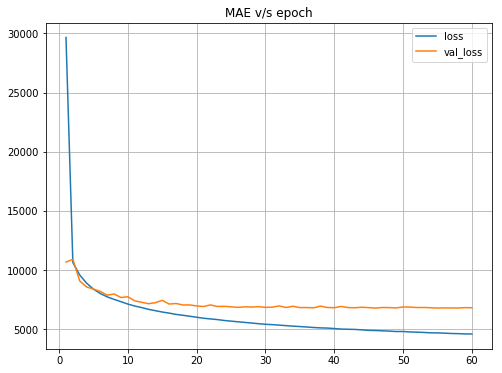

val_loss at epoch 60: 6802.856741


In [77]:
fig = plt.figure(figsize=(8,6))
plt.title("MAE v/s epoch")
plt.grid(True)
plt.plot(1+np.arange(len(history['loss'])),history['loss'],label='loss')
plt.plot(1+np.arange(len(history['val_loss'])),history['val_loss'],label='val_loss')
plt.legend(loc="upper right")
plt.show()

print("val_loss at epoch %d: %f"%(len(history['val_loss']),history['val_loss'][-1]))

> A continuación se muestra un pantallazo durante el entrenamiento (en los computadores del INCA)

![Entrenamiento](part3/train.png)